In [1]:
import os
import numpy as np
from uuid import uuid4
import pandas as pd
import sqlalchemy
from sqlalchemy import insert
from sqlalchemy.orm import declarative_base
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy import (
   Column,
   UUID,
   Text,
   TIMESTAMP,
   Double,
   Integer,
   Numeric,
   ARRAY,
)
import os
from urllib.parse import quote_plus
from pc_zap_scrapper.v2.scrape import get_estates_from_page, get_html_page, get_number_of_pages, get_number_of_real_estates
from pc_zap_scrapper.v2.database import DatabaseHandler, TableRealEstateInfo


Base = declarative_base()


class DatabaseHandler:
    def __init__(self, db_params: dict, table: sqlalchemy.orm.decl_api.DeclarativeMeta, echo: bool = False):
        db_url = (
            f"postgresql+asyncpg://{db_params['user']}:{db_params['password']}@"
            f"{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
        )
        self.table = table
        self.engine = create_async_engine(db_url, echo=echo)
        self.async_session = sessionmaker(self.engine, class_=AsyncSession, expire_on_commit=False)

    async def create_table(self):
        async with self.engine.begin() as conn:
            await conn.run_sync(Base.metadata.create_all)

    async def insert_data(self, df: pd.DataFrame):
        records = df.to_dict(orient="records")

        async with self.async_session() as session:
            async with session.begin():
                await session.execute(insert(self.table).values(records))
                await session.commit()
    
    async def query(self, sql_query: str) -> pd.DataFrame:
        async with self.engine.connect() as conn:
            result = await conn.execute(sqlalchemy.text(sql_query))
            rows = result.fetchall()
            columns = result.keys()
            df = pd.DataFrame(rows, columns=columns)
            return df


    async def close(self):
        await self.engine.dispose()


In [ ]:
db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)

sql_query = """
SELECT * FROM real_estate_info
"""

data = await db_handler.query(sql_query)

await db_handler.close()

In [ ]:
pd.options.display.max_columns = None

In [ ]:
old = pd.read_parquet("/app/pc_zap_scrapper/datasets/imoveis_pc_v01.parquet")

old = old.drop(
    columns = [
        "id",
        "search_id",
        "n_floors",
        "units_on_floor",
        "n_suites",
        "resale",
        "buildings",
        "plan_only",
        "pois_list",
    ]
)

old = old.rename(
    columns = {
        "n_parking_spaces": "number_of_parking_spaces",
        "n_bathrooms": "number_of_bathrooms",
        "n_bedrooms": "number_of_rooms",
        "area": "floor_size",
        "id_zap": "estate_id",
        "amenities": "amenities_list",
        "description": "snippet",
        "neighborhood": "neighbor",
        "condo_fee": "condominium",
        
    }
)
old["id"] = [uuid4() for i in range(len(old))]
old["action"] = "venda"
old["post_type"] = None
old["image_list"] = None

In [6]:
old["type"] = old["type"].replace(
    {
        "HOME": "Casa",
        "APARTMENT": "Apartamento",
        "OFFICE": None,
        "RESIDENTIAL_ALLOTMENT_LAND": "Lote",
        "CONDOMINIUM": "Apartamento",
        "SHED_DEPOSIT_WAREHOUSE": "Comercial",
        'TWO_STORY_HOUSE': None,
        "COMMERCIAL_ALLOTMENT_LAND": "Lote",
        "PENTHOUSE": None,
        "BUSINESS": "Comercial",
        "COUNTRY_HOUSE": "Rural",
        "ALLOTMENT_LAND": "Lote",
        "HOTEL": None,
        "FARM": "Rural",
        "FLAT": "Flat",
        "COMMERCIAL_PROPERTY": "Comercial",
        "COMMERCIAL_BUILDING": "Comercial",
        "KITNET": "Apartamento",
        "BUILDING": None,
    }
)

In [7]:
old = old[data.columns]

In [26]:
from importlib import resources
from unidecode import unidecode

def _format_neighbor_name(text: str) -> str:
    if text:
        return unidecode(text.strip().lower())
    return None

pc_neighbors_latlong = (
    pd.read_parquet(resources.files("pc_zap_scrapper").joinpath("datasets/external/neighbor_latlong.parquet"))
    .set_index("neighborhood")
    .to_dict(orient="index")
)

pc_neighbors_latlong = {_format_neighbor_name(k): v for k, v in pc_neighbors_latlong.items() if k}

import numpy as np
old["latitude"] = np.where(old["latitude"].isna(), old["neighbor"].apply(lambda x: pc_neighbors_latlong.get(_format_neighbor_name(x), {}).get("latitude", None)), old["latitude"])
old["longitude"] = np.where(old["longitude"].isna(), old["neighbor"].apply(lambda x: pc_neighbors_latlong.get(_format_neighbor_name(x), {}).get("longitude", None)), old["longitude"])


In [27]:
old.head(3)

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
0,5767f6c3-3dc4-4678-96e4-0d249dff9ce3,2503300374,venda,2021-06-04,None,/imovel/venda-casa-3-quartos-jardim-das-horten...,Casa,None,Casa no Jardim das Hortênsias- Poços de Caldas...,None,Jardim Das Hortênsias,Poços de Caldas,MG,-21.804587,-46.542271,100.0,3.0,3.0,2.0,[],420000.0,NaN,NaN
1,2966030a-15f3-4316-9dd6-712d15142d5f,2462358530,venda,2021-06-04,None,/imovel/venda-apartamento-3-quartos-centro-poc...,Apartamento,None,Apartamento na Rua Assis Figueiredo de aproxim...,Rua Assis Figueiredo,Centro,Poços de Caldas,MG,-21.780617,-46.566830,128.0,3.0,3.0,2.0,"[GATED_COMMUNITY, ELEVATOR, SERVICE_AREA, BALC...",950000.0,0.0,0.0
2,d1aee0d8-867a-4abf-bca3-c468b4a25242,70958901,venda,2021-06-04,None,/imovel/venda-apartamento-3-quartos-com-churra...,Apartamento,None,"03 quartos (01 suíte), sala ampla para 02 ambi...",None,Jardim Elvira Dias,Poços de Caldas,MG,-21.786572,-46.605375,115.0,3.0,4.0,2.0,"[BARBECUE_GRILL, KITCHEN, ELEVATOR, GOURMET_BA...",590000.0,636.0,0.0


In [28]:
data.head(3)

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
0,fc495ad4-19d8-46a5-a6a8-065e5258d52e,2635911061,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-apa...,Apartamento,[https://resizedimgs.zapimoveis.com.br/crop/61...,Apartamento com 3 quartos à venda,,Jardim dos Estados,Poços de Caldas,MG,-21.783975,-46.552999,235.0,3.0,1.0,2.0,"[Cozinha, Elevador, Interfone, Área de serviço]",800000.00,700.00,0.00
1,ff0af6b2-ef1b-4070-ae2f-0a6312c47157,2753629515,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 4 quartos à venda,,Boa Esperança,Poços de Caldas,MG,-21.826302,-46.557761,219.0,4.0,4.0,3.0,None,450000.00,NaN,NaN
2,02007133-c21e-4dc9-9e2f-34e9d95e92d6,2756849948,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,Jardim Carolina,Poços de Caldas,MG,-21.793090,-46.601182,131.0,3.0,4.0,3.0,"[Circuito de segurança, Portaria 24h, Espaço g...",820000.00,NaN,NaN


In [177]:
[k for k in pc_neighbors_latlong if "cascat" in k]

['jardim cascatinha']

In [29]:
ACTION="venda"
TYPE="imoveis"
LOCALIZATION="mg+pocos-de-caldas"

db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)


In [34]:

from pc_zap_scrapper.v2.models import RealEstateInfo, ZapImoveisURL
from pc_zap_scrapper.v2.utils import get_integer_fields, suppress_errors_and_log

integer_columns = get_integer_fields(RealEstateInfo)

for col in integer_columns:
    old[col] = old[col].astype("Int64")

old = old.where(pd.notnull(old), None)

In [40]:
await db_handler.insert_data(old.iloc[100:])

In [52]:
# n = 1000
# for i in range(100,len(old),n):
#     print(i,i+n)
#     await db_handler.insert_data(old.iloc[i:i+n])

# Análise de Dados

In [ ]:
!pip install matplotlib -qqq

In [54]:
db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)

sql_query = """
SELECT * FROM real_estate_info
"""

data = await db_handler.query(sql_query)

await db_handler.close()

In [77]:
data["search_date"] = data["search_date"].dt.strftime('%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101929 entries, 0 to 101928
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        101929 non-null  object 
 1   estate_id                 101929 non-null  object 
 2   action                    101929 non-null  object 
 3   search_date               101929 non-null  object 
 4   post_type                 5481 non-null    object 
 5   link                      101654 non-null  object 
 6   type                      100412 non-null  object 
 7   image_list                5591 non-null    object 
 8   snippet                   101802 non-null  object 
 9   street                    86529 non-null   object 
 10  neighbor                  101884 non-null  object 
 11  city                      101927 non-null  object 
 12  state                     98773 non-null   object 
 13  latitude                  101803 non-null  f

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.ticker as mticker


def percentile_plot(casas, ylim, title):
    average_price_by_date = casas.groupby("search_date").agg(
        **{f"p{i}": ("price", lambda x, q=min(i/100,1): np.quantile(x, q)) for i in range(0,101,10)}
    ).reset_index()
    
    
    average_price_by_date['search_date'] = pd.to_datetime(average_price_by_date['search_date'])
    
    average_price_by_date = average_price_by_date.set_index("search_date")
    
    if 'search_date' in average_price_by_date.columns:
        average_price_by_date['search_date'] = pd.to_datetime(average_price_by_date['search_date'])
        average_price_by_date.set_index('search_date', inplace=True)
    else:
        average_price_by_date.index = pd.to_datetime(average_price_by_date.index)
    
    average_price_by_date.sort_index(inplace=True)
    
    percentiles = [f'p{i}' for i in range(0, 101, 10)]  # ['p0', 'p10', ..., 'p100']
    
    plt.figure(figsize=(15, 8))
    
    # Define as cores desejadas
    colors = ["#BBC7DC", "#A1B5D0", "#87A2C5", "#6D90B9", "#6D90B9"]
    
    
    for i in range(1, 9):
        lower = average_price_by_date[percentiles[i]]
        upper = average_price_by_date[percentiles[i+1]]
        
        if i <= 4:
            color_index = i - 1
        else:
            color_index = 8 - i
        
        plt.fill_between(
            average_price_by_date.index,
            lower,
            upper,
            facecolor=colors[color_index],
            edgecolor=colors[color_index],
            linewidth=1,
            alpha=1,
            label=f'{i*10}-{(i+1)*10}º percentil'
        )
    
    # for percentile in percentiles:
    for percentile in ['p50']:
        plt.plot(
            average_price_by_date.index,
            average_price_by_date[percentile],
            color='black',
            linewidth=1.5,
            alpha=0.5
        )
    
    # Configurações do eixo X (formatação das datas)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.ylim(ylim)
    plt.title(title)
    
    # **Formatação do eixo Y para unidades monetárias**
    def formato_monetario(valor, pos):
        return f'R${valor:,.0f}'.replace(',', '.')
    
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(formato_monetario))
    
    plt.legend(title='Intervalos Percentis', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    plt.grid()
    plt.show()


# Preço das casas ao longo do tempo

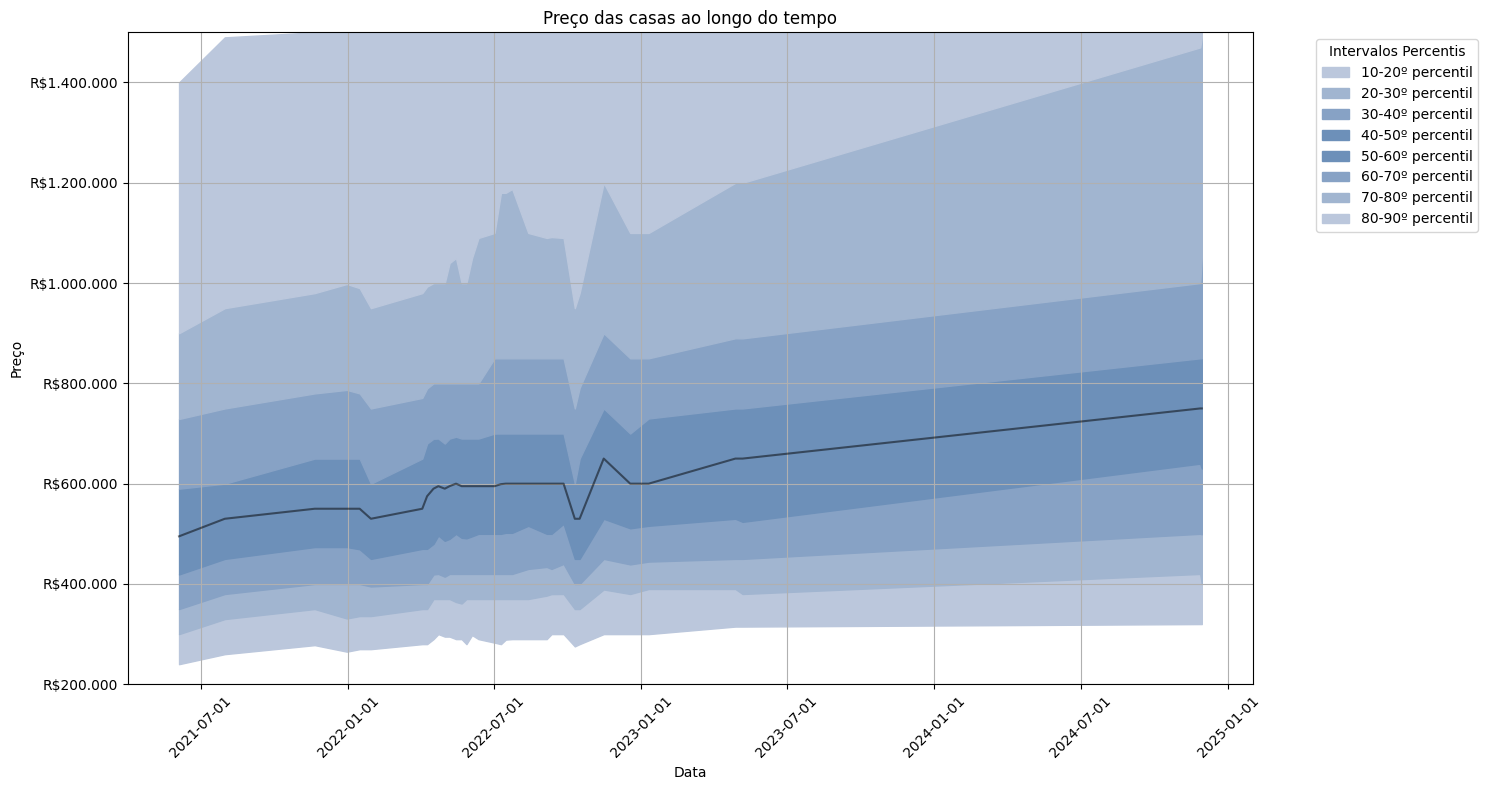

In [222]:
casas = data[data["type"] == "Casa"]
casas = casas[~casas["price"].isna()]
casas = casas[casas["price"] > 0]
casas["price"] = casas["price"].astype(float)
percentile_plot(casas, ylim=[200_000, 1_500_000], title="Preço das casas ao longo do tempo")

# Preço dos aparamentos ao longo do tempo

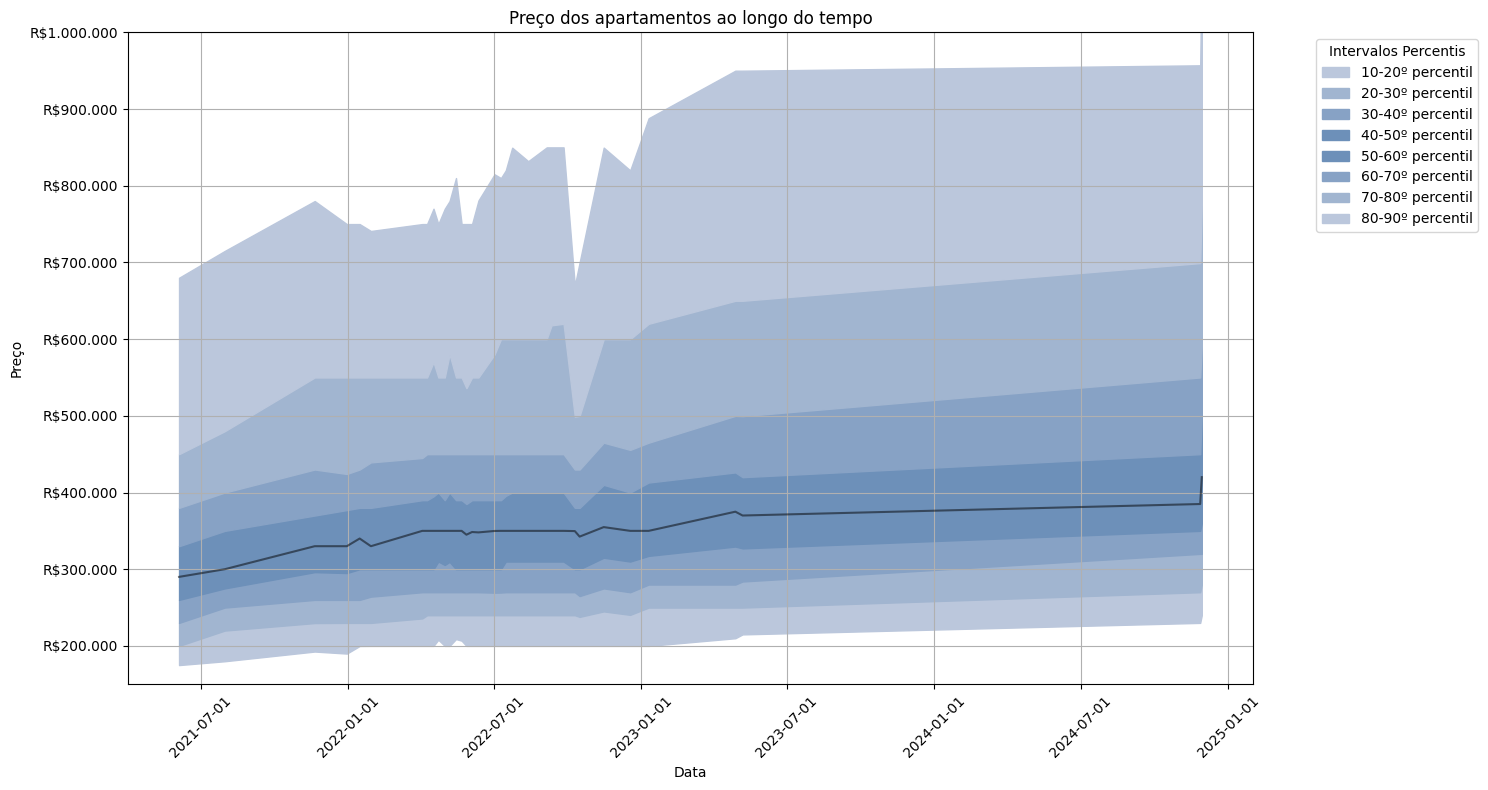

In [223]:
apartamentos = data[data["type"] == "Apartamento"]
apartamentos = apartamentos[~apartamentos["price"].isna()]
apartamentos = apartamentos[apartamentos["price"] > 0]
apartamentos["price"] = apartamentos["price"].astype(float)
percentile_plot(apartamentos, ylim=[150_000, 1_000_000], title="Preço dos apartamentos ao longo do tempo")

# Preço dos lotes ao longo do tempo

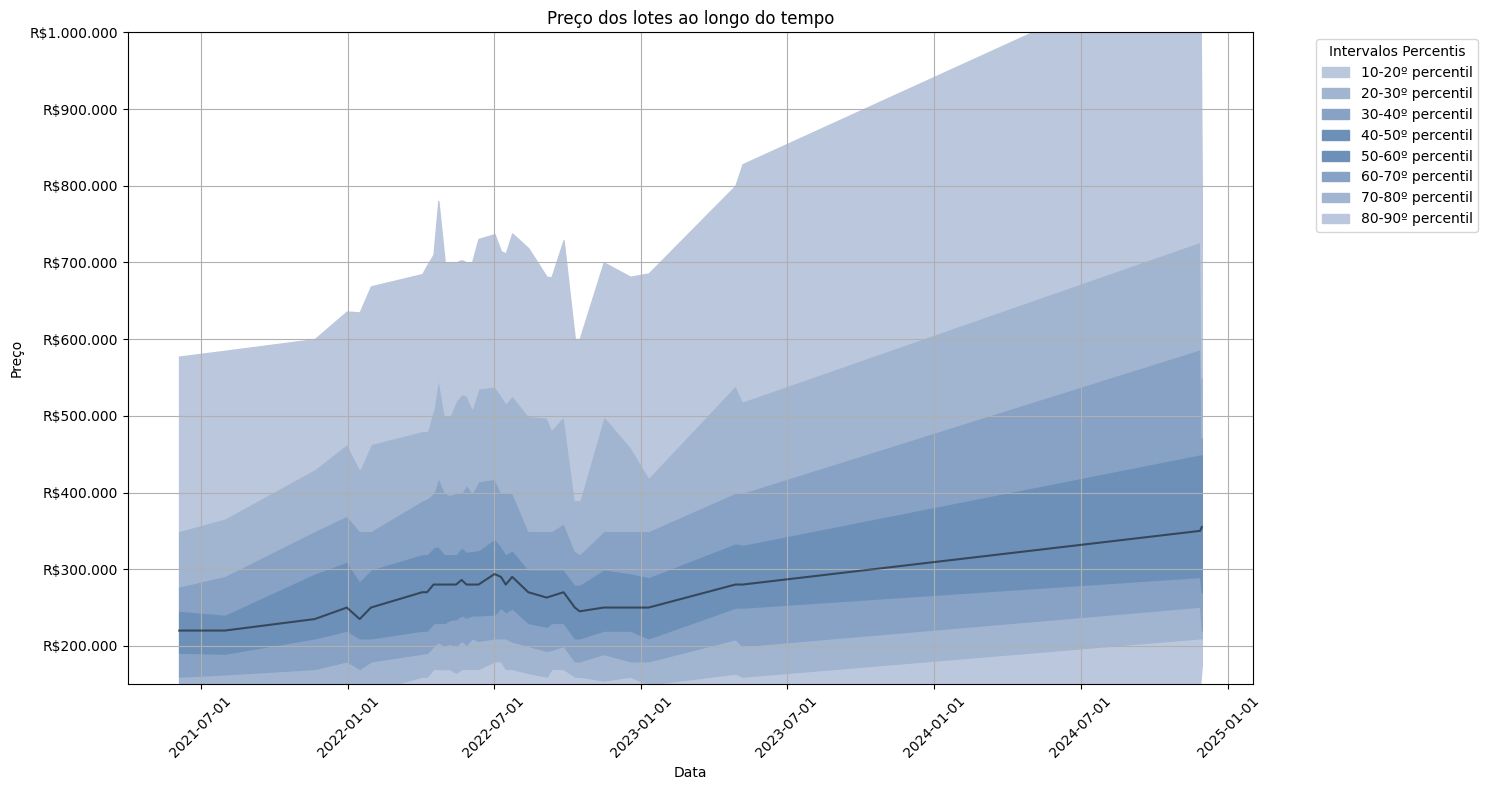

In [226]:
lotes = data[data["type"] == "Lote"]
lotes = lotes[~lotes["price"].isna()]
lotes = lotes[lotes["price"] > 0]
lotes["price"] = lotes["price"].astype(float)
percentile_plot(lotes, ylim=[150_000, 1_000_000], title="Preço dos lotes ao longo do tempo")

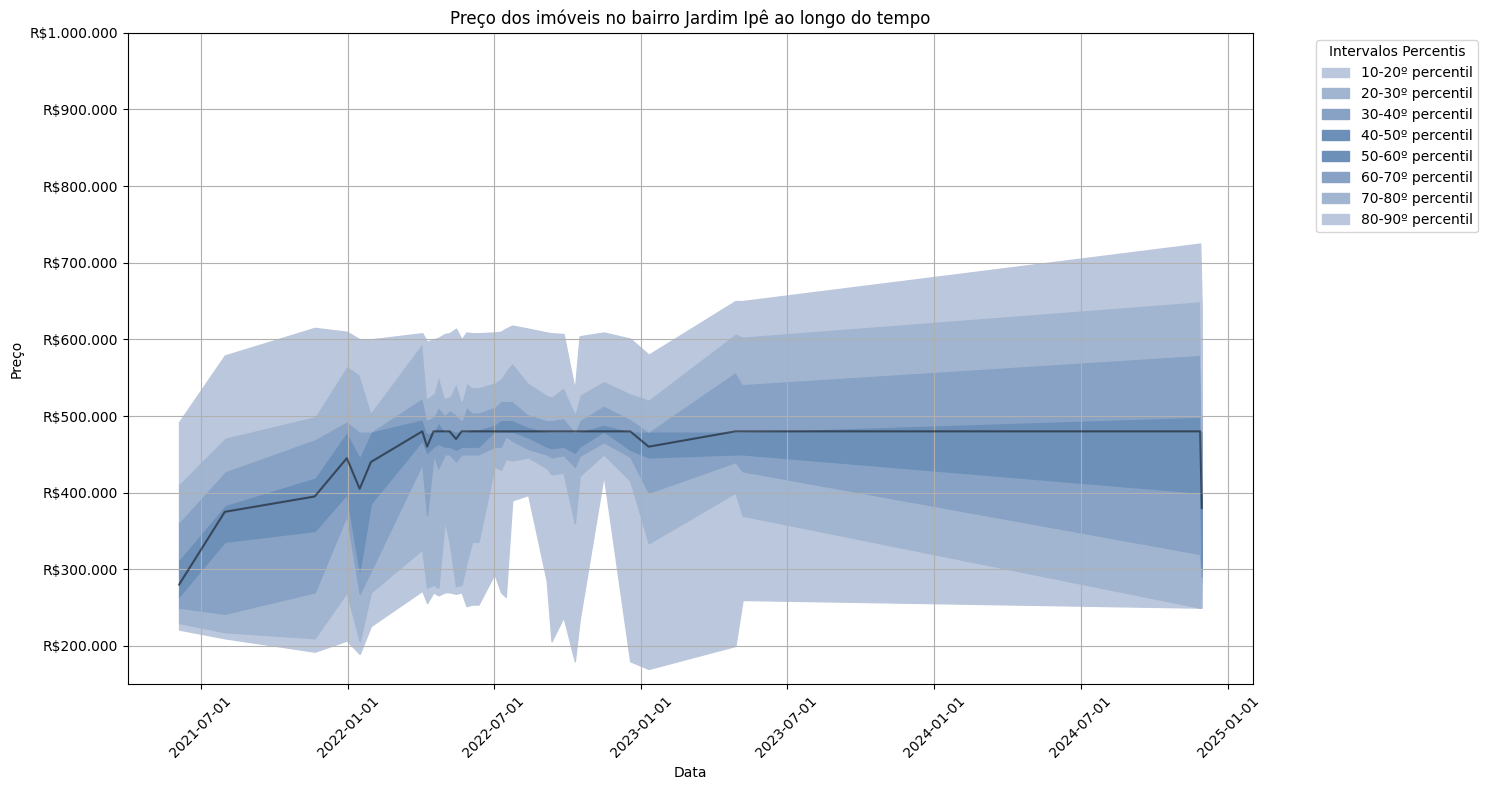

In [259]:
# neighbor_name = pd.Series(data["neighbor"].unique()).sample().iloc[0]


neighbor_name = "Jardim Ipê"
bairro = data[data["neighbor"] == neighbor_name]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)
percentile_plot(bairro, ylim=[150_000, 1_000_000], title=f"Preço dos imóveis no bairro {neighbor_name} ao longo do tempo")

In [258]:
data[data["neighbor"].fillna("").str.contains("Ipê")]

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
3,476271bb-6912-4e8f-acdb-f9389ab87124,2635633461,venda,2024-11-27,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com quarto à venda,,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,63.0,1.0,1.0,NaN,None,250000.00,NaN,NaN
156,5bb8164f-6041-4013-bfff-f5aa97df48d0,2741708923,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,135.0,3.0,1.0,2.0,"[Churrasqueira, Interfone, Cozinha, Área de se...",400000.00,NaN,NaN
335,7a95f5a3-e510-4d59-a951-791309aaabf5,2757607715,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,148.0,3.0,2.0,2.0,[Área de serviço],480000.00,NaN,NaN
387,b10f5c4a-2fa5-4d3c-8cbb-cf6b5c79a0cf,2741838582,venda,2024-11-27,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,127.0,3.0,2.0,2.0,None,350000.00,0.00,64.00
464,2d8b387b-d160-4f70-87b2-82ebfd99db4a,2503300333,venda,2021-07-31,None,/imovel/venda-casa-3-quartos-com-interfone-jar...,Casa,None,Casa no bairro Jardim Ipê-Poços de Caldas MG<b...,None,Jardim Ipê,Poços de Caldas,MG,-21.802998,-46.543752,100.0,3.0,1.0,2.0,[INTERCOM],380000.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101504,beea7b46-1920-4263-b110-64b26f236c2d,2626248796,venda,2023-05-07,None,/imovel/venda-casa-3-quartos-jardim-ipe-pocos-...,Casa,None,Casa térrea com 150 m² de área edificada.<br><...,,Jardim Ipê,Poços de Caldas,MG,-21.799761,-46.547920,150.0,3.0,1.0,2.0,[],650000.00,0.00,0.00
101513,18591f3c-f22e-40d3-b78f-35b88a4d8e13,2568097194,venda,2023-05-07,None,/imovel/venda-casa-3-quartos-com-churrasqueira...,Casa,None,Casa em Poços de Caldas!!!<br>03 quartos sendo...,,Jardim Ipê,Poços de Caldas,MG,-21.799761,-46.547920,270.0,3.0,1.0,1.0,"[BARBECUE_GRILL, INTERCOM]",700000.00,0.00,0.00
101551,3ae35068-5a9d-4b92-a398-98efa217d0fa,2568097293,venda,2023-05-07,None,/imovel/venda-casa-2-quartos-com-quintal-jardi...,Casa,None,Casa no bairro Jardim Ipê - Poços de Caldas MG...,,Jardim Ipê,Poços de Caldas,MG,-21.799761,-46.547920,104.0,2.0,1.0,2.0,"[BACKYARD, SERVICE_AREA]",480000.00,0.00,0.00
101572,8208c2fc-d764-4331-a6c8-2e718b9ead2e,2568092760,venda,2023-05-07,None,/imovel/venda-casa-3-quartos-com-churrasqueira...,Casa,None,"Casa, localizada no bairro Jardim Ipê, na regi...",,Jardim Ipê,Poços de Caldas,MG,-21.799761,-46.547920,240.0,3.0,1.0,1.0,[BARBECUE_GRILL],450000.00,0.00,0.00
